# Finding clusters of abalone
_Given a dataset containing information on abalone, can we find an optimal clustering for them?_

## Table of contents
1. [Data ingestion](#Data-ingestion)
2. [Data preprocessing](#Data-preprocessing)
3. [EDA](#EDA)
4. [Model Training](#Model-Training)
5. [Credits](#Credits)

## Data ingestion

### Introduction

Thanks to UCI Machine Learning Group for providing the dataset, which can be found [here](https://archive.ics.uci.edu/ml/datasets/Abalone).  

From the UCI MLG page, the columns are detailed as follows:  

Format: **Name** / Data Type / Measurement Unit / Description

**Sex** / nominal / -- / M, F, and I (infant)  
**Length** / continuous / mm / Longest shell measurement  
**Diameter** / continuous / mm / perpendicular to length  
**Height** / continuous / mm / with meat in shell  
**Whole weight** / continuous / grams / whole abalone  
**Shucked weight** / continuous / grams / weight of meat  
**Viscera weight** / continuous / grams / gut weight (after bleeding)  
**Shell weight** / continuous / grams / after being dried  
**Rings** / integer / -- / +1.5 gives the age in years  


### Initial thoughts

For this dataset, we will be performing a clustering operation using various clustering algorithms. We will also be automating the selection of the optimal-K value for this clustering for future use in 5411's clustering feature. Let's begin by opening the dataset and looking at what we have.

## Data preprocessing

We begin by importing the abalone dataset into our notebook and checking for null values. 

In [1]:
# import data science packages
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# import k means methods
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score

#import elbow method algorithm
from kneed import KneeLocator

df = pd.read_csv("abalone.csv")
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [2]:
print("Presence of null values: " + str(df.isnull().values.any()))

Presence of null values: False


There are no null values in our dataset, which is nice. We can now encode our categorical data to be a numerical value. This means that our 'sex' column will be 3 different numbers. 

In [3]:
lbl = LabelEncoder()
df['sex'] = lbl.fit_transform(df['sex'])
keys = lbl.classes_
values = lbl.transform(lbl.classes_)
mapping = dict()
dictionary = dict(zip(keys, values))
print(dictionary)

{'F': 0, 'I': 1, 'M': 2}


Now we can analyze some of our data before we begin clustering. 

## EDA

First,  let's make a correlation graph of our column values and see what has the strongest trends.

In [4]:
import seaborn as sns 

corr = df.corr()
sns.heatmap(corr)

Judging from the heatmap, there are a lot of correlation points between the physical attributes of the abalone. There isn't much of a correlation between the sex and the physical attributes, however. 

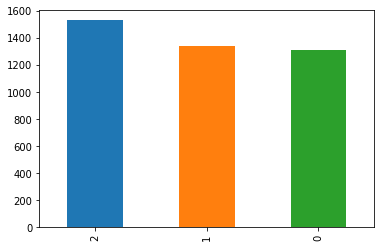

In [5]:
pd.value_counts(df['sex']).plot.bar()

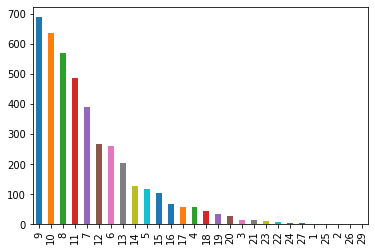

In [6]:
pd.value_counts(df['rings']).plot.bar()

From the above two plots, we can see that there are roughly equal distributions of M, F, and I genders. For the rings, it appears that the most common numbers of rings range from 7 to 11, while other numbers of rings are rarer in comparison. 

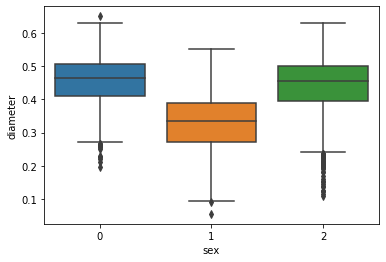

In [7]:
sns.boxplot(x = 'sex', y = 'diameter', data = df)

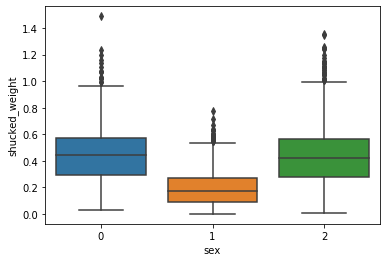

In [8]:
sns.boxplot(x = 'sex', y = 'shucked_weight', data = df)

From the boxplots, we can see that the M, F sexes are very similar in physical size and type. Potential use cases for this information include food consumptio (e.g fishermen can prioritize M/F type abalone since they are larger). Let's try to remove some of the outliers present within the dataset so we can get a clearer picture. 

In [9]:
males = df[df['sex'] == 2]
females = df[df['sex'] == 0]
infants = df[df['sex'] == 1]

quantile_male = males['shucked_weight'].quantile(0.90)
quantile_female = females['shucked_weight'].quantile(0.90)
quantile_infant = infants['shucked_weight'].quantile(0.90)

males[males['shucked_weight'] < quantile_male]
females[females['shucked_weight'] < quantile_female]
infants[infants['shucked_weight'] < quantile_infant]

frames = [males, females, infants]
df = pd.concat(frames)
print(len(df.index))

4177


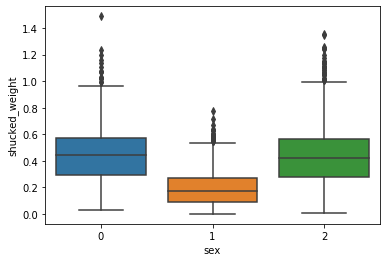

In [10]:
sns.boxplot(x = 'sex', y = 'shucked_weight', data = df)

Let's try building our clustering model with the abalone.

## Model Training

We will be using different clustering algorithms and analyzing their performances while running our automated K-selection code. 

### K-Means (elbow method)

We can also profile the time it takes to cluster the dataset with each algorithm with the '%time' command.

Wall time: 72.5 ms
Wall time: 80.1 ms
Wall time: 109 ms
Wall time: 159 ms
Wall time: 143 ms
Wall time: 165 ms
Wall time: 191 ms
Wall time: 251 ms

Number of clusters: 4


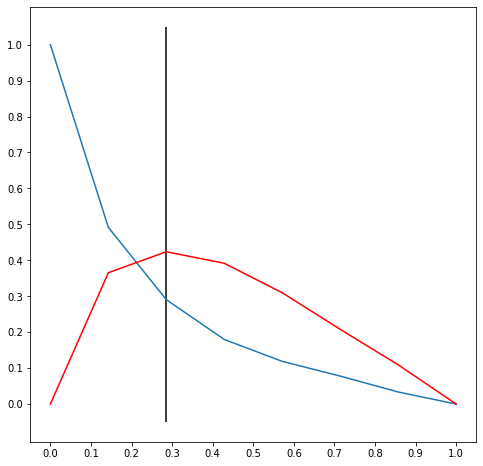

In [11]:
# hold error value for elbow method calculation
error = []


for i in range(2, 10):
    kmeans = KMeans(n_clusters = i)
    %time kmeans.fit(df)
    error.append(kmeans.inertia_)

# find the elbow of the graph using kneed package   
optimalK = KneeLocator(
    range(2, 10),
    error,
    curve = 'convex',
    direction = 'decreasing',
    interp_method = 'interp1d',
)

# print number of clusters for dataset
print("\nNumber of clusters: " + str(optimalK.elbow))
optimalK.plot_knee_normalized()

# create optimal K graph for prediction model 
kmeans = KMeans(n_clusters = optimalK.elbow)

We can then plot the clustering for this dataset given by KMeans.

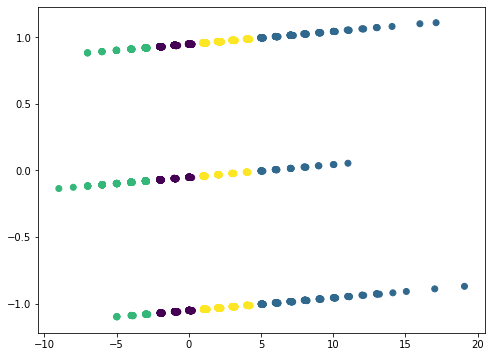

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = 2)
new_df = pca.fit_transform(df)
model = KMeans(n_clusters = optimalK.elbow).fit(new_df)

plt.figure(figsize=(8, 6))
plt.scatter(new_df[:,0], new_df[:,1], c=model.labels_.astype(float))

### K-Means (silhouette)

Wall time: 96.6 ms
Wall time: 86.9 ms
Wall time: 107 ms
Wall time: 150 ms
Wall time: 152 ms
Wall time: 203 ms
Wall time: 201 ms
Wall time: 242 ms

Number of clusters: 2


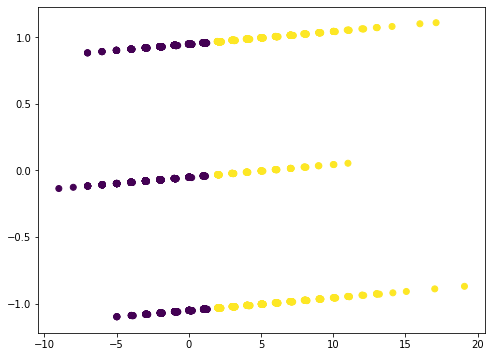

In [13]:
silhouette_vals = dict()
optimalK = 0

for i in range(2, 10):
    kmeans = KMeans(n_clusters = i)
    %time cluster_labels = kmeans.fit_predict(df)
    silhouette_vals[i] = silhouette_score(df, cluster_labels)

silhouette_optimalK = max(silhouette_vals, key=silhouette_vals.get)
print("\nNumber of clusters: " + str(silhouette_optimalK))

pca = PCA(n_components = 2)
new_df = pca.fit_transform(df)
model = KMeans(n_clusters = silhouette_optimalK).fit(new_df)

plt.figure(figsize=(8, 6))
plt.scatter(new_df[:,0], new_df[:,1], c=model.labels_.astype(float))

For this dataset, it seems that the silhouette method gives the best K value for the dataset. However, we had to use PCA to visualize the data on a 2-D space, so the graph is difficult to interpret as a result. 

### Spectral Clustering (silhouette)

Below is the code given for the spectral clustering algorithm in sklearn. 

In [14]:
# error contains error value for each value of k
optimalK = 0
silhouette_vals = dict()

# iterate through possible k values to set up optimization graph
for i in range(2, 10):
    sc = SpectralClustering(i)
    %time spectral_cluster_labels = sc.fit_predict(df)
    silhouette_vals[i] = silhouette_score(df, spectral_cluster_labels)
    
silhouette_optimalK = max(silhouette_vals, key=silhouette_vals.get)
print("\nNumber of clusters: " + str(silhouette_optimalK))

Wall time: 6.23 s
Wall time: 6.01 s
Wall time: 5.88 s
Wall time: 6.07 s
Wall time: 6.12 s
Wall time: 6.38 s
Wall time: 6.19 s
Wall time: 5.66 s

Number of clusters: 2


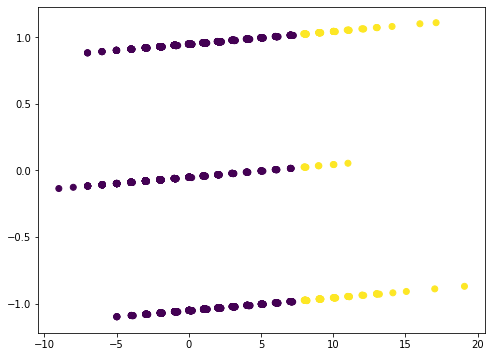

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
new_df = pca.fit_transform(df)
model = SpectralClustering(silhouette_optimalK).fit_predict(new_df)

plt.figure(figsize=(8, 6))
plt.scatter(new_df[:,0], new_df[:,1], c=model.astype(float))


We can see that spectral clustering is very slow for this dataset compared to KMeans, and KMeans still gives a good clustering as seen in the PCA analysis. Therefore, it is better to use KMeans for this dataset. 

## Credits

Thanks again to the UCI Machine Learning Group for providing the dataset. 